In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.special import expit
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from mapra import prep
from mapra.prep import save

sns.set_theme(style='white')
rng = np.random.default_rng(12345)


Notes?

In [2]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
spearman_rhos = data.fetch_spearman_rhos(npr)
delta_labels = data.order
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:52: UserWarning: found not exactly one TSV with annotations:
/home/quirin/PYTHON/mapra/prothermdb_annotations.tsv
/home/quirin/PYTHON/mapra/uniprot_to_pdb.tsv
/home/quirin/PYTHON/mapra/uniprot_to_pdb_unmapped.tsv
  warnings.warn('found not exactly one TSV with annotations:\n' + '\n'.join(str(tsv) for tsv in tsvs))


loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

In [3]:
# loop either over the test_size or the number of selected columns

test_sizes = [.8, .4, .2, .1, 0]
column_numbers = [64, 1024]

if False:
    desc = '%d columns'
    params = column_numbers
    test_size = .2
else:
    desc = 'test size: %.1f'
    params = test_sizes
    n_columns = 1024


In [11]:
store = dict()
for row, param in enumerate(params):

    # sort out which one we're looping
    if desc.startswith('%d'):
        n_columns = param
    elif desc.startswith('t'):
        test_size = param
    else:
        assert False

    ars = list()
    all_cols = list()
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # # select the correct, best-fitting columns
        # rhos = abs(spearman_rhos[delta])
        # cols = np.argpartition(rhos, -n_columns)[-n_columns:]
        # all_cols.append(cols)
        #
        # # select the correct columns, shift because the measured value is in column 0
        # dnpr = dnpr[:, [0] + [c + 1 for c in cols]]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        if test_size:
            # split into test and training data
            X, X_test, y, y_true = train_test_split(
                X, y, test_size=test_size, random_state=35)
        else:
            # use the entire set for both training and testing -> over-fitting
            X, X_test, y, y_true = X, X, y, y

        print('\n')
        regr = linear_model.LassoLarsCV()
        # LassoCV(alphas=np.arange(.001, .1, .01))  # Lasso(alpha=0.01)
        regr.fit(X, y.flatten())
        cols = [i for i, c in enumerate(regr.coef_) if c > 0]
        all_cols.append(cols)
        print(f'{len(cols)} non-zero coefficients')
        print(regr.alpha_)

        # make a prediction
        y_pred = regr.predict(X_test).reshape(-1, 1)
        # save the prediction
        ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, y_true)))
    store[row] = ars, all_cols
'done'



100 non-zero coefficients
0.004571057084437601


55 non-zero coefficients
0.003188227716608901


118 non-zero coefficients
0.0012646489377193756


79 non-zero coefficients
0.0029525903415757943


128 non-zero coefficients
0.000889784303377599


200 non-zero coefficients
0.0003038740582694284


189 non-zero coefficients
0.000890868607576765


180 non-zero coefficients
0.00041362876284923975


197 non-zero coefficients
0.00027489325648880395


183 non-zero coefficients
0.0008189811595826077


126 non-zero coefficients
0.0005738100913633071


201 non-zero coefficients
0.0002559962753741417


40 non-zero coefficients
0.005451971106497191


31 non-zero coefficients
0.0025127707176875454


48 non-zero coefficients
0.0013800208717790123


'done'

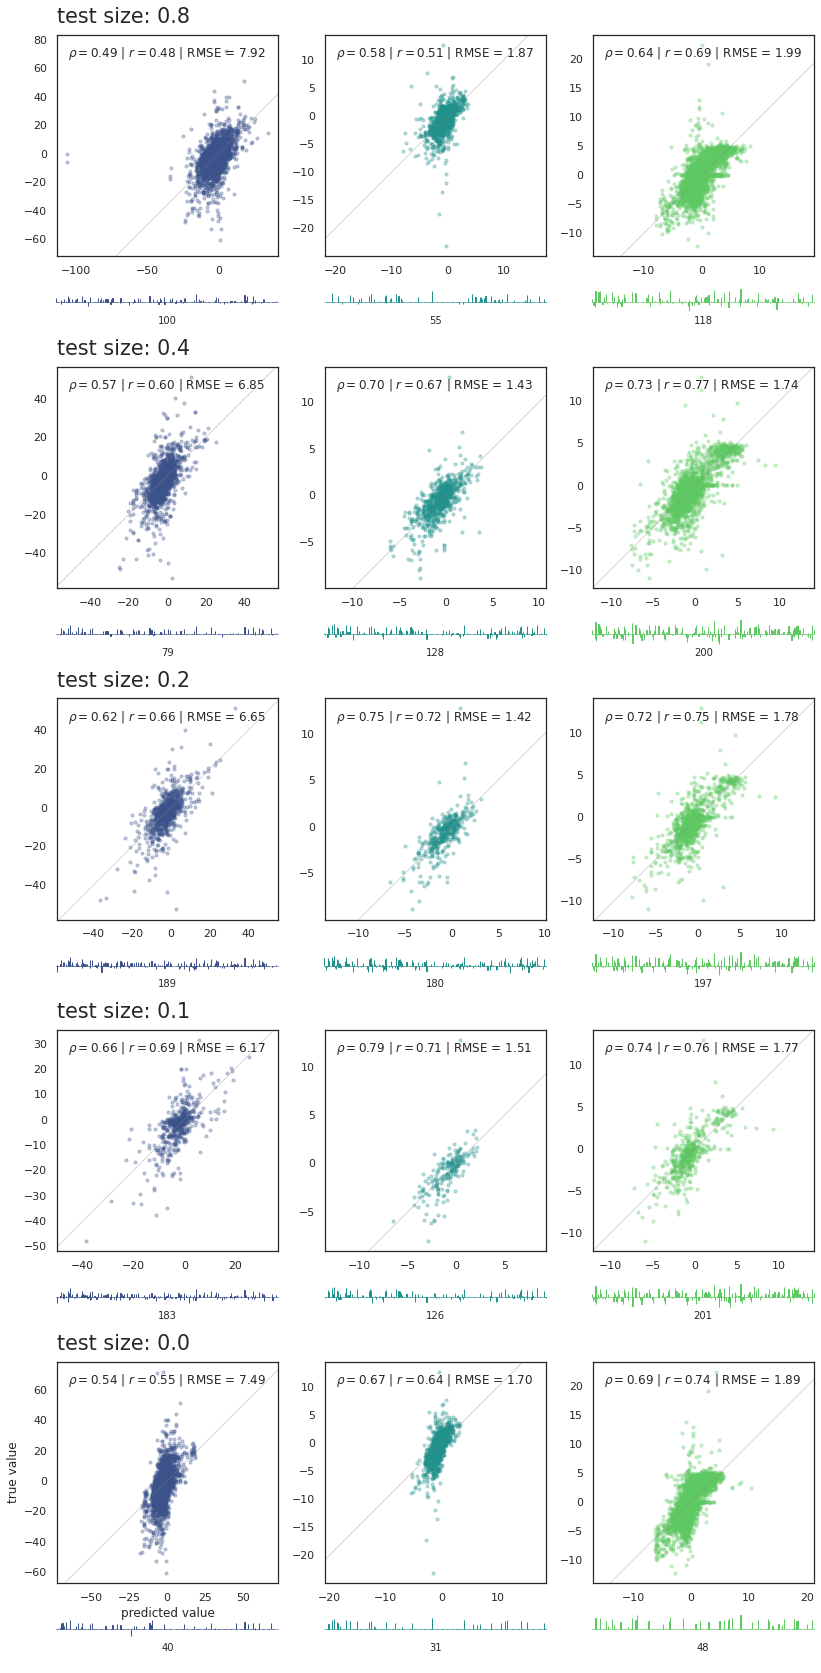

In [18]:
fig, axes = plt.subplots(2 * len(params), 3, figsize=(13.6, 6 * len(params)),
                         gridspec_kw={'height_ratios': [1, .25] * len(params), 'width_ratios': [1, 1, 1]})
cmap = sns.color_palette('viridis', 3)

for row, param in enumerate(params):
    ars, all_cols = store[row]

    for i, (ax, ax_cor, ar, delta, cols) in enumerate(
            zip(axes[2 * row, :], axes[2 * row + 1, :], ars, delta_labels, all_cols)):
        sns.regplot(ax=ax,
                    x=ar[:, 1], y=ar[:, 2],
                    color=cmap[i],
                    # marker='+',
                    scatter_kws={'s': 10, 'alpha': .3},
                    fit_reg=False, logistic=True)

        ax.set(aspect=1, box_aspect=1)
        # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
        ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

        # correlations
        sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
        pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
        rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
        r2 = r2_score(ar[:, 2], ar[:, 1])

        # ax.text(.05, .7, data.tex_lookup[delta] + '\n'
        #         + r"$\rho = $" + f'{sp:.2f}, ' + r"$r = $" + f'{pcorr:.2f}\nRMSE = {rmse:.2f}\nr² = {r2:.2f}',
        #         transform=ax.transAxes)
        ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
                transform=ax.transAxes)

        # ax_cor.axvline(x=512, lw=.5, color='.5', alpha=.8)
        ax_cor.bar(list(range(1024)), [co if idx in cols else 0 for idx, co in enumerate(spearman_rhos[delta])],
                   edgecolor=cmap[i], alpha=1)
        ax_cor.set_title(f'{len(cols)}', fontsize='small', pad=-40)
        ax_cor.set_xlim(-1, 1024)
        ax_cor.set_axis_off()
        ax_cor.set_ylim(-1, .5)

        axes[2 * row, 0].set_title(desc % param, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[-2, 0].set(ylabel='true value', xlabel='predicted value')
save(fig, f'lassolars_{desc % param}.png')

In [ ]:
for j in [3]:
    for ax in axes[j, :]:
        fig.delaxes(ax)
# axes[2, 0].set_title('train and test on full sets', loc='left', fontsize='xx-large', pad=12)
axes[2, 0].set_title('all 1024 columns', loc='left', fontsize='xx-large', pad=12)
# fig.tight_layout()
fig

In [ ]:
save(fig, f'linear_regr_{soll_size}_{desc % param}_noaxes.png')

In [ ]:
axes[2, 0].set_title('train and test on full sets')
fig

In [ ]:
axes[2, 0].set_title('all 1024 columns', loc='left', fontsize='xx-large', pad=12)
# save(fig, f'linear_regr_{desc % param}_noaxes.png')
fig


### make line plots showing the optimal test size
number of columns, RMSE, Spearman's rho
alpha, r², Pearson's r
x: test size

In [63]:
def dodo(seed=rng.integers(low=0, high=1000, size=1)[0]):
    test_sizes = np.arange(0, 1, .05)

    results = np.zeros((len(test_sizes) * 3, 9))
    for row, test_size in enumerate(test_sizes):
        for i, delta in enumerate(delta_labels):
            print(f'\n{row} {i} {delta}')
            # select the rows for this delta, and cleave off the delta column
            dnpr = npr[npr[:, 0] == i, 1:]
            # split into features and labels
            X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)
            # make a test split
            if test_size:
                # split into test and training data
                X, X_test, y, y_true = train_test_split(
                    X, y, test_size=test_size, random_state=seed)
            else:
                # use the entire set for both training and testing -> over-fitting
                X, X_test, y, y_true = X, X, y, y

            regr = linear_model.LassoLarsCV()
            # LassoCV(alphas=np.arange(.001, .1, .01))  # Lasso(alpha=0.01)
            regr.fit(X, y.flatten())
            n_cols = len([i for i, c in enumerate(regr.coef_) if c > 0])
            print(f'{n_cols} non-zero coefficients, alpha {regr.alpha_}')

            # make a prediction
            y_pred = regr.predict(X_test).reshape(-1, 1)
            ar = np.hstack((y_pred, y_true))
            # evaluate the prediction
            sp, pval = scipy.stats.spearmanr(ar, axis=0)
            pcorr = np.corrcoef(ar, rowvar=False)[0, 1]
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            r2 = r2_score(y_true, y_pred)

            results[row * 3 + i, :] = i, test_size, n_cols, rmse, sp, pval, regr.alpha_, r2, pcorr

    np.save(str(Path('.').resolve().parent / 'txts' / f'{seed}.npy'), results)
    print('done')
    return results

In [67]:
WD = Path('.').resolve()
results = [dodo(k) for k in range(4)]


0 0 dtemp
40 non-zero coefficients, alpha 0.005451971106497191

0 1 ddg
31 non-zero coefficients, alpha 0.0025127707176875454

0 2 h2o
48 non-zero coefficients, alpha 0.0013800208717790123

1 0 dtemp
189 non-zero coefficients, alpha 0.0007718188037541397

1 1 ddg
136 non-zero coefficients, alpha 0.0005255527839206876

1 2 h2o
202 non-zero coefficients, alpha 0.0002564854116850146

2 0 dtemp
192 non-zero coefficients, alpha 0.0007650296770611123

2 1 ddg
131 non-zero coefficients, alpha 0.0005382666928939186

2 2 h2o
196 non-zero coefficients, alpha 0.00025942487654749617

3 0 dtemp
185 non-zero coefficients, alpha 0.000823128663836295

3 1 ddg
139 non-zero coefficients, alpha 0.0004902634311665869

3 2 h2o
194 non-zero coefficients, alpha 0.00025832554748513037

4 0 dtemp
173 non-zero coefficients, alpha 0.0010745754283854481

4 1 ddg
132 non-zero coefficients, alpha 0.0005602652426063911

4 2 h2o
199 non-zero coefficients, alpha 0.00026325465281750734

5 0 dtemp
142 non-zero coeffici

/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


30 non-zero coefficients, alpha 0.008162073858637157

19 0 dtemp
42 non-zero coefficients, alpha 0.0214543957227955

19 1 ddg
0 non-zero coefficients, alpha 0.11363892465208802

19 2 h2o


/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


27 non-zero coefficients, alpha 0.018328207400408244
done

0 0 dtemp
40 non-zero coefficients, alpha 0.005451971106497191

0 1 ddg
31 non-zero coefficients, alpha 0.0025127707176875454

0 2 h2o
48 non-zero coefficients, alpha 0.0013800208717790123

1 0 dtemp
188 non-zero coefficients, alpha 0.0008156315651612289

1 1 ddg
177 non-zero coefficients, alpha 0.00036117856853440334

1 2 h2o
208 non-zero coefficients, alpha 0.0002487108316424507

2 0 dtemp
185 non-zero coefficients, alpha 0.0008155832273137504

2 1 ddg
164 non-zero coefficients, alpha 0.00040859061307255726

2 2 h2o
209 non-zero coefficients, alpha 0.0002577262218555862

3 0 dtemp
173 non-zero coefficients, alpha 0.0009894244153688743

3 1 ddg
166 non-zero coefficients, alpha 0.0004282400517042704

3 2 h2o
207 non-zero coefficients, alpha 0.00025345134432103113

4 0 dtemp
172 non-zero coefficients, alpha 0.0009607477240946673

4 1 ddg
120 non-zero coefficients, alpha 0.0006687009022419645

4 2 h2o
200 non-zero coefficients, a

In [114]:
ar = np.vstack(results)
np.save(str(Path('.').resolve().parent / 'txts' / f'optimize_test_size.npy'), ar)
ar.shape

(240, 9)

In [4]:
ar = np.load(str(Path('.').resolve().parent / 'txts' / f'optimize_test_size.npy'))
df = pd.DataFrame(ar, columns=['delta', 'x', 'n_cols', 'rmse', 'sp',
                               'pval', 'alpha', 'r2', 'pcorr'])\
    .drop(columns=['pval'])\
    .melt(id_vars=['delta', 'x'], var_name='box', value_name='y')
df


,delta,x,box,y
0,0.0,0.00,n_cols,40.000000
1,1.0,0.00,n_cols,31.000000
2,2.0,0.00,n_cols,48.000000
3,0.0,0.05,n_cols,189.000000
4,1.0,0.05,n_cols,136.000000
...,...,...,...,...
1435,1.0,0.90,pcorr,0.466129
1436,2.0,0.90,pcorr,0.658758
1437,0.0,0.95,pcorr,0.305586
1438,1.0,0.95,pcorr,0.271019


/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


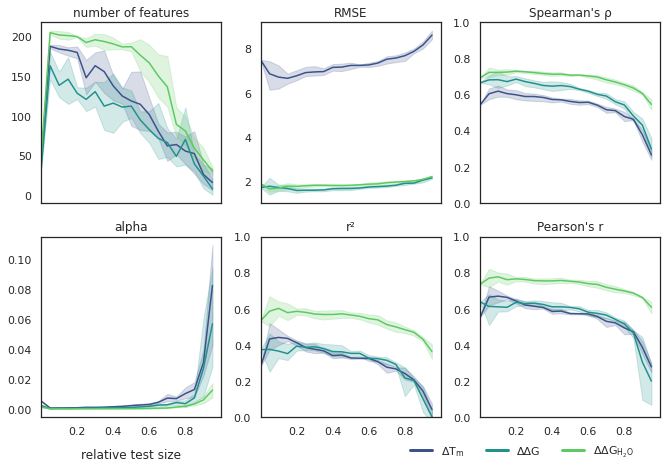

In [26]:
sns.set_theme(style='white')
cmap = sns.color_palette('viridis', 3)
import matplotlib.lines as mlines

relabel = lambda legend: [t.set_text(data.tex_lookup[t.get_text()]) for t in legend.texts]

g = sns.FacetGrid(data=df, col='box', col_wrap=3,
                  col_order=['n_cols', 'rmse', 'sp', 'alpha', 'r2', 'pcorr' ],
                  height=3.2,
                  margin_titles=True, sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x='x', y='y',
                hue='delta', hue_order=[0, 1, 2], palette=dict(enumerate(cmap)),
                markers=False, dashes=False)
# scatter_kws={'s': 10, 'alpha': .05})

# mess around with the legend
handles = list()
for de, co in zip(delta_labels, cmap):
    handles.append(mlines.Line2D([], [], color=co, label=data.tex_lookup[de], linewidth=3))

g.add_legend(title='', bbox_to_anchor=(.72, 0), ncol=3, handles=handles)
g.set(xlim=(0, 1))

g.set_titles(col_template='{col_name}')
for ax, lab in zip(g.axes.flatten(), ['number of features', 'RMSE', 'Spearman\'s ρ',
                                      'alpha', 'r²', 'Pearson\'s r']):
    ax.set_title(lab)

for i, ax in enumerate(g.axes.flatten()):
    ax.set(box_aspect=1)
    ax.set(xticks=[.2, .4, .6, .8])
    # Drawing the frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    if i in {2, 4, 5}:
        ax.set(ylim=(0, 1))

g.axes[3].set_xlabel('relative test size', labelpad=12)

# g.tight_layout()
# g.fig.subplots_adjust(hspace=-.1)
save(g, f'optimize_test_size.png')

In [22]:
dict(enumerate(cmap))


{'dtemp': (0.229739, 0.322361, 0.545706),
 'ddg': (0.127568, 0.566949, 0.550556),
 'h2o': (0.369214, 0.788888, 0.382914)}

### compare  to
number of columns, RMSE, Spearman's rho
alpha, r², Pearson's r
x: test size
